# <span style="color:STEELBLUE">**Set Up**</span>

### Import libraries and data

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, r2_score, classification_report

import math

from collections import defaultdict

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/master_df_20191103.xlsx"
data = pd.read_excel(file)
df_master = pd.DataFrame(data).set_index('FIPS')

In [3]:
print(df_master.columns)

Index(['PropSFHA', 'PropDG', 'AveLS', 'MaxDepth', 'HurTrack', 'PeakGust',
       'MaxSusta', 'StrVI', 'SeVI', 'Str+SeVI', 'SoVI', 'AveDepth', 'O_Ind',
       'R_Ind', 'PropSComm', 'R_I_No0', 'R_I_NoO', 'R_I_No0_NoO', 'cat_3q',
       'cat_4q', 'Count', 'R_DES', 'R_AFF'],
      dtype='object')


### Choose Data

In [4]:
def choose_data(df_master, feature_list, target_list):
    choices = feature_list + target_list
    df = df_master[choices].copy()
    df.dropna(inplace = True)
    return df

In [5]:
# EXAMPLE:
feature_list = ['PropSFHA', 'PropDG', 'AveLS', 'HurTrack',
                'PeakGust', 'StrVI', 'SeVI', 'AveDepth', 'PropSComm']
target_list = ['R_I_No0']

df = choose_data(df_master, feature_list, target_list)

In [6]:
# ### DELETE
# df = df[df.O_Ind != 0]

# <span style="color:STEELBLUE">**Explore Features**</span>


In [17]:
def histogram_figure(df_target):
    fig, ax = plt.subplots(1,1,figsize=(6, 4))
    plt.rcParams["patch.force_edgecolor"] = True
    sns.distplot(df_target.values,kde=False)
    fig.text(0.5, 0.02, 'Proportion of Damaged Homes by Census Tract', ha='center')
    ax.set_title('Damage Index ', fontsize = 20)

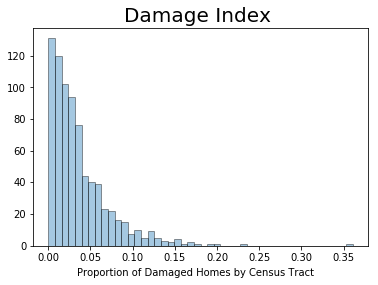

In [82]:
#EXAMPLE:
df_target = df['R_I_No0']
histogram_figure(df_target)

In [83]:
def boxplot_figure(df, target):
    fig, ax = plt.subplots(1,1,figsize=(4, 6))
    ax = df.boxplot(column=target, showfliers=True)
    ax.set_ylabel("Proportion of Damaged Homes by Census Tract")

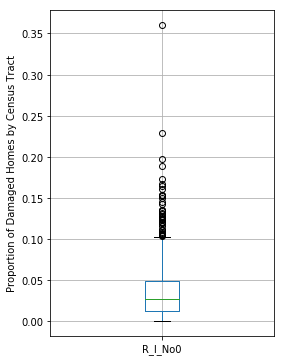

In [84]:
#EXAMPLE:
target = ['R_I_No0']
boxplot_figure(df, target)

Spearman

In statistics, Spearman's rank correlation coefficient or Spearman's rho, named after Charles Spearman and often denoted by the Greek letter (rho), is a nonparametric measure of rank correlation (statistical dependence between the rankings of two variables). It assesses how well the relationship between two variables can be described using a monotonic function.

The Spearman correlation between two variables is equal to the Pearson correlation between the rank values of those two variables; while Pearson's correlation assesses linear relationships, Spearman's correlation assesses monotonic relationships (whether linear or not). If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other.

In [87]:
def spearman_matrix(df):
    plt.figure(figsize = (9,9))
    hm = sns.heatmap(df.corr(method = 'spearman'),
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':15})


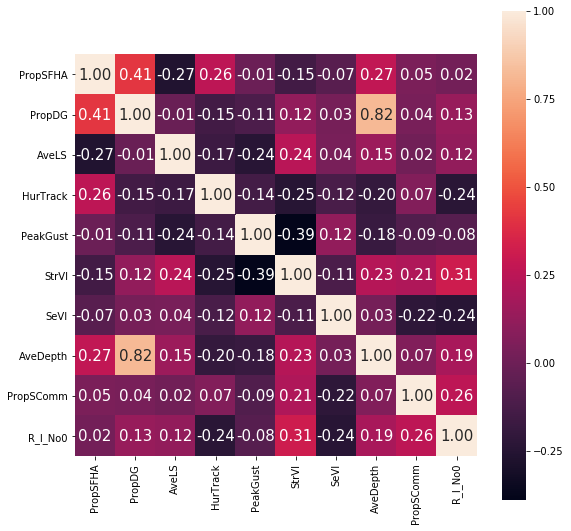

In [88]:
#EXAMPLE:
spearman_matrix(df)

In [89]:
def feature_matrix(df, target):
    fig = scatter_matrix(df, c=target, figsize = [15,15])
    for ax in fig.ravel():
        ax.set_xlabel(ax.get_xlabel(), fontsize = 12, rotation = 45)
        ax.set_ylabel(ax.get_ylabel(), fontsize = 12, rotation = 45, ha='right')


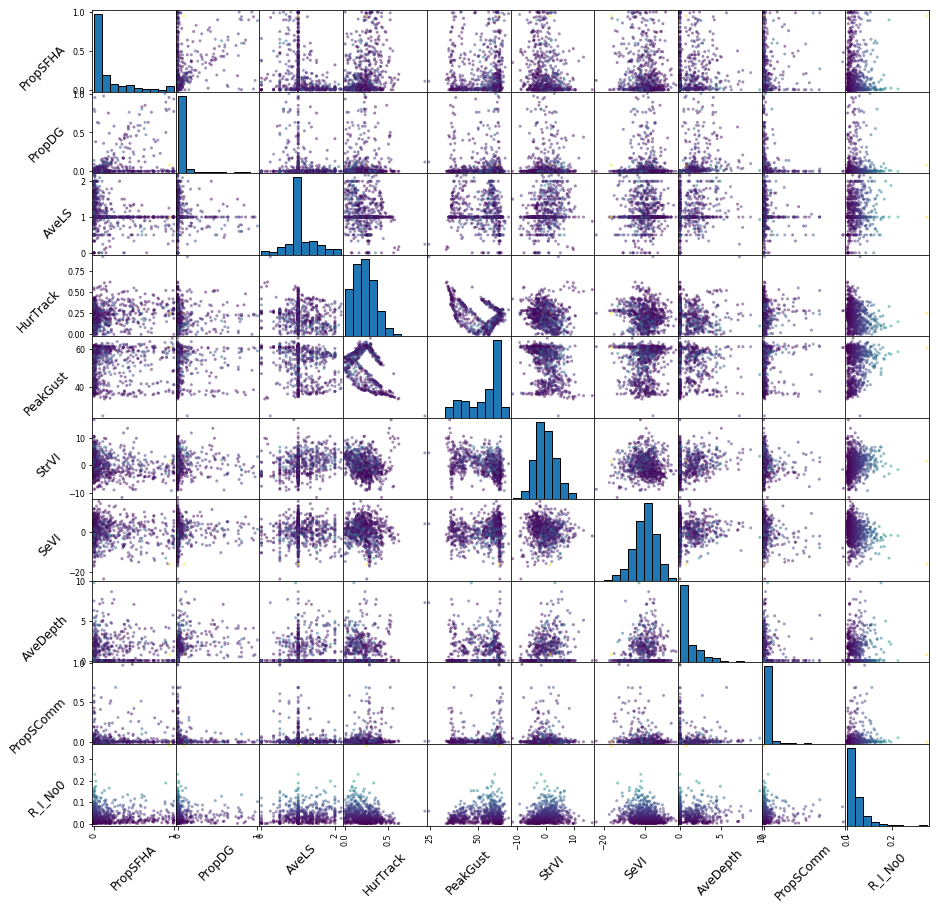

In [90]:
#EXAMPLE:
target = df['R_I_No0']
feature_matrix(df, target)

### Partition and Bin Data

In [27]:
def partition_data(df, target_str):
    y = df[target_str]
    df_x = df.drop(target_str, axis = 1)
    return y, df_x

In [28]:
# EXAMPLE:
target_str = 'R_I_No0'
y, df_x = partition_data(df, target_str)

In [29]:
def bin_target(y, n_bins, label):
    y_binned = pd.qcut(y, q=n_bins, labels = label)
    return y_binned

In [30]:
# EXAMPLE:
y_binned = bin_target(y,4, [0,1,2,3])

### Train, Test, Split

In [31]:
def split_the_data(df_x, y):
    x_train, x_test, y_train, y_test = train_test_split(df_x, y, 
                                                        test_size=0.2, 
                                                        random_state=42,
                                                        stratify = y_binned)
    return x_train, x_test, y_train, y_test


In [32]:
# Careful of Random State
# EXAMPLE:
x_train, x_test, y_train, y_test = split_the_data(df_x, y)

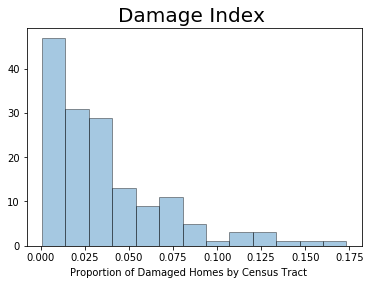

In [35]:
histogram_figure(y_test)

### Step 1: Randomized Search CV

In [97]:
def randomized_cv(x_train, y_train, model):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = model
    # Random search of parameters, using cv = cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_randomized_cv = RandomizedSearchCV(estimator = rf, 
                                          param_distributions = random_grid, 
                                          n_iter = 100, 
                                          cv = 5, 
                                          verbose=2, 
                                          random_state=42, 
                                          n_jobs = -1)
    
    # Fit the random search model
    rf_randomized_cv.fit(x_train, y_train)
    
    print(rf_randomized_cv.best_params_)
    return rf_randomized_cv.best_estimator_
    

In [98]:
#EXAMPLE
#Random state
#CHOOSE IF REGRESSOR OR CLASSIFICATION
random_tuned_model = randomized_cv(x_train, y_train, RandomForestRegressor())

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV]  n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40, total=   4.1s
[CV] n_estimators=1788, min_sa

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.5s


[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   1.7s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   1.7s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   1.7s
[CV] n_estimators=1577, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100 
[CV]  n_estimators=1788, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, total=   5.6s
[CV] n_estimators=1577, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   1.7s
[CV] n_estimators=1577, min_samples

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   56.6s


[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, total=   5.3s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, total=   5.2s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, total=   1.8s
[CV] n_estimators=311, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, total=   1.8s
[CV] n_estimators=311, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, total=   1.9s
[CV] n_estimators=311, min_sample

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.4min


[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   3.7s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, total=   2.3s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   3.6s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   3.6s
[CV] n_estimators=944, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   3.6s
[CV] n_estimators=944, min_samples_split

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.3min finished


{'n_estimators': 1577, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30}


In [100]:
random_tuned_model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=1577, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

### Step 2: Grid Search CV

In [103]:
def grid_cv(x_train, y_train, model):
    param_grid = {
        'max_depth': [20, 30, 50, 100],
        'max_features': [2, 3, 4],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [5, 8, 10],
        'n_estimators': [1000, 1500]
    }
    # Create a based model
    rf = model
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, 
                               param_grid = param_grid, 
                               cv = 5, n_jobs = -1, 
                               verbose = 2)
    grid_search.fit(x_train, y_train)
    
    print(grid_search.best_params_)
    return grid_search.best_estimator_

In [104]:
#Example
#CHOOSE IF REGRESSOR OR CLASSIFICATION
tuned_model = grid_cv(x_train, y_train, RandomForestRegressor())

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1500 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1500 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1500 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, total=   2.1s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.4s


[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1500, total=   2.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1500, total=   2.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1500, total=   2.8s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1500 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1500, total=   2.8s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1500 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1000, total=   1.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   53.3s


[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1500, total=   3.5s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1500, total=   3.5s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=1500 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1500, total=   3.5s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=1500 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1500, total=   3.5s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=1500 
[CV]  max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=1000, total=   2.2s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.3min


[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1500, total=   3.3s
[CV] max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1500 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1500, total=   3.2s
[CV] max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1500 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   2.3s
[CV] max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1500 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   2.3s
[CV] max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   2.5s
[CV] max_depth=30, max_features=3, min_samples_leaf=3, min_sampl

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.2min


[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, total=   2.5s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, total=   2.5s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, total=   2.5s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=1500, total=   3.8s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   2.5s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_spl

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.6min


[CV]  max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=5, n_estimators=1500, total=   3.7s
[CV] max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=1500 
[CV]  max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=5, n_estimators=1500, total=   3.7s
[CV] max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=1500 
[CV]  max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   2.4s
[CV] max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=1500 
[CV]  max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   2.5s
[CV] max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   2.5s
[CV] max_depth=100, max_features=4, min_samples_leaf=3, min_

[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  7.2min finished


{'max_depth': 20, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}


In [105]:
tuned_model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)>

# <span style="color:STEELBLUE">**Run Models**</span>

### Tuned Model - will either be regression or classification depending on what you chose in the tune functions

In [106]:
def run_tuned_model(x_train,y_train):
    tuned_model.fit(x_train, y_train)
    return tuned_model

In [107]:
hypertune_model = run_tuned_model(x_train, y_train)

----------------

### Standard Regression Model

In [19]:
def run_regression(x_train, y_train):
    reg_model = RandomForestRegressor(random_state=42, n_estimators=1000, min_samples_split=10, 
                                      max_depth = 40, max_features=2, min_samples_leaf=4) 
    reg_model.fit(x_train, y_train)
    return reg_model

In [20]:
# EXAMPLE
# Careful of Random State
reg_model = run_regression(x_train, y_train)

----------------

### Standard Classification Model

In [764]:
def run_classification(x_train, y_train,):
    class_model = RandomForestClassifier(random_state=42)
    class_model.fit(x_train, y_train)
    return class_model

In [765]:
# EXAMPLE
# Careful of Random State
class_model = run_classification(x_train, y_train)

# <span style="color:STEELBLUE">**Evaluate Models**</span>

### Make Predictions

In [108]:
def prediction(model, x_train, x_test):
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)   
    return pred_train, pred_test

In [109]:
# EXAMPLE
#CHOOSE MODEL
pred_train, pred_test = prediction(hypertune_model, x_train, x_test)

### Evaluate Regression

In [110]:
def evaluate_regression(pred_train, pred_test, y_train, y_test):
    r_train = r2_score(y_train, pred_train)
    print('The training r-squared score is {}'.format(r_train))
    r_test = r2_score(y_test, pred_test)
    print('The testing r-squared score is {}'.format(r_test))
    meanabserrors_train = np.mean(abs(pred_train - y_train))
    print('The training mean absolute error is {}'.format(meanabserrors_train))
    meanabserrors_test = np.mean(abs(pred_test - y_test))
    print('The testing mean absolute error is {}'.format(meanabserrors_test))
    rmse = math.sqrt(mean_squared_error(y_test, pred_test))
    print('The root mean square error is {}'.format(rmse))
    mse = mean_squared_error(y_test, pred_test)
    print('The mean square error is {}'.format(mse))
    errors = pred_test - y_test
    meanerror = np.mean(errors)
    print('The mean error is {}'.format(meanerror))
    return errors

In [111]:
# EXAMPLE
errors = evaluate_regression(pred_train, pred_test, y_train, y_test)

The training r-squared score is 0.4977821093221687
The testing r-squared score is 0.25606588142729114
The training mean absolute error is 0.016116351841104184
The testing mean absolute error is 0.022549493913134107
The root mean square error is 0.0336225495098924
The mean square error is 0.0011304758355451655
The mean error is -0.002645962261074819


In [112]:
def analyze_errors(errors):
    error_range =  max(errors) - min(errors)
    print('The error range is {}'.format(error_range))
    error_max = max(errors)
    print('The error max is {}'.format(error_max))
    error_min = min(errors)
    print('The error min is {}'.format(error_min))

In [113]:
# EXAMPLE
analyze_errors(errors)

The error range is 0.22971290596873986
The error max is 0.04919186345152013
The error min is -0.18052104251721973


In [114]:
def plot_errors(errors):
    plt.hist(errors, 30, histtype='bar', ec='white', color='maroon')
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.title('Histogram of Model Error')
    plt.grid(True)
    plt.show()


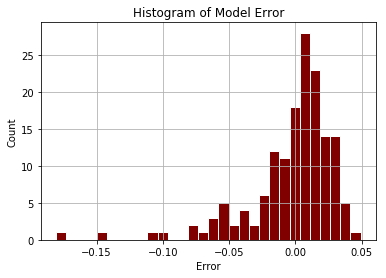

In [115]:
# EXAMPLE
plot_errors(errors)

In [116]:
def plot_predictions(y_test, pred):
    df_predictions = pd.DataFrame(y_test)
    df_predictions['Pred'] = pred
    X = df_predictions.iloc[:, 0].values.reshape(-1, 1)
    Y = df_predictions.iloc[:, 1].values.reshape(-1, 1)
    fig, ax = plt.subplots()
    ax.scatter(X, Y, color='maroon')
    line = mlines.Line2D([0, 1], [0, 1], color='orange')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)    
    plt.grid(True)
    plt.xlabel("Damage Index")
    plt.ylabel("Precited Damage Index")
    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
    plt.title('Model Evaluation - Test Set')
    plt.show()

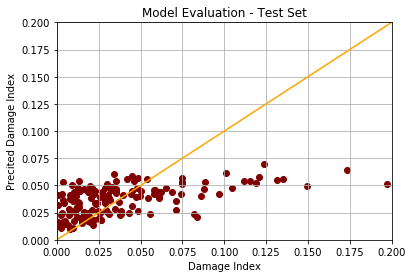

In [117]:
# EXAMPLE
plot_predictions(y_test, pred_test)

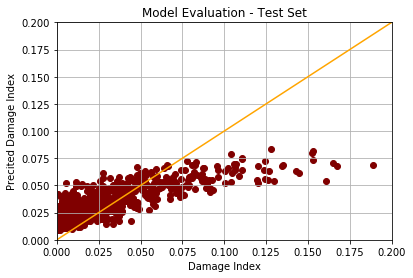

In [118]:
plot_predictions(y_train, pred_train)

-----------

### Evaluate Classification

In [766]:
def evaluate_classification(model, x_train, x_test, y_train, y_test):
    pred = model.predict(x_test)
    accuracy_train = model.score(x_train, y_train)
    print('The mean training accuracy is {}'.format(accuracy_train))
    accuracy_test = model.score(x_test, y_test)
    print('The mean test accuracy is {}'.format(accuracy_test))
    df_confusion = pd.DataFrame(confusion_matrix(y_test, pred))
    print(df_confusion)
    print(classification_report(y_test, pred))
    return df_confusion

In [767]:
# EXAMPLE
# CHOOSE MODEL IF WANT TUNED OR JUST CLASSIFICATION WITH DEFAULT
df_confusion = evaluate_classification(class_model, x_train, x_test, y_train, y_test)

The mean training accuracy is 0.9843971631205674
The mean test accuracy is 0.5028248587570622
    0   1   2
0  29  10  15
1  16  25  15
2  17  15  35
             precision    recall  f1-score   support

          0       0.47      0.54      0.50        54
          1       0.50      0.45      0.47        56
          2       0.54      0.52      0.53        67

avg / total       0.50      0.50      0.50       177



In [768]:
def plot_confusion(df_confusion):
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_confusion, cmap='PuBu', annot=True, annot_kws={"size": 16})# font size
    plt.ylabel('Predicted')
    plt.xlabel('True Value')
    plt.show()

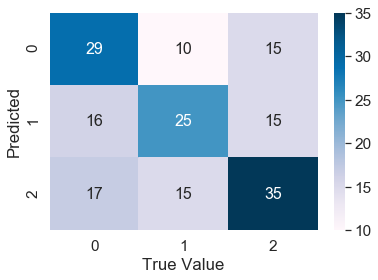

In [769]:
# EXAMPLE
plot_confusion(df_confusion)

# <span style="color:STEELBLUE">**Analyze Results**</span>

## Gini Importance Calculation

Tree based models provides a different measure of feature importances based on the mean decrease in impurity (MDI, the splitting criterion - The function to measure the quality of a split. Supported criteria are “mse” for the mean squared error, which is equal to variance reduction as feature selection criterion, and “mae” for the mean absolute error). This gives importance to features that may not be predictive on unseen data. The permutation feature importance avoids this issue, since it can be applied to unseen data. Furthermore, impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features). Permutation-based feature importances do not exhibit such a bias. Additionally, the permutation feature importance may use an arbitrary metric on the tree’s predictions. These two methods of obtaining feature importance are explored in: Permutation Importance vs Random Forest Feature Importance (MDI).

In scikit-learn, importance of a node 𝑗 in a decision tree is computed (source code) as: \
![alt text](nodeimportance.png "Title") \
where 𝑤𝑗 is weighted number of samples in node 𝑗, 𝐶𝑗 is impurity in this node, and 𝑙𝑒𝑓𝑡(𝑗) and 𝑟𝑖𝑔ℎ𝑡(𝑗) are its respective children nodes.

Then feature importance of feature 𝑖 is computed as:\
![alt text](featureimportance.png "Title") \
In RandomForest or GradientBoosting, feature importances are then averaged over all the trees (source code).

In short, (un-normalized) feature importance of a feature is a sum of importances of the corresponding nodes. So if you take a set of features, it would be totally consistent to represent the importance of this set as sum of importances of all the corresponding nodes. And the latter exactly equals sum of individual feature importances. And normailizing denominator is the same for all the features, so does not change relative importances.

In [119]:
def calc_gini_importances(x_train, model):
    importances = model.feature_importances_
    importances_df = pd.DataFrame(importances, x_train.columns,
                                  columns=['Importance']).sort_values('Importance',
                                  ascending=False)
    importances_df.reset_index(inplace=True)
    importances_df.rename(columns={'index':'Feature'}, inplace=True)
    return importances_df


In [121]:
# indicate if reg_model or class_model
# EXAMPLE
df_gini_importances = calc_gini_importances(x_train, hypertune_model)

## Gini Plot

In [122]:
def gini_importance_plot(df_gini_importances):
    df_gini_importances.sort_values('Importance', ascending=False).plot.bar('Feature',
                                                                            'Importance', 
                                                                            color='maroon', 
                                                                            legend = False)
    plt.title("Feature Importances", fontsize = 30)
    plt.ylabel('Importance')
    plt.xlabel('')
    plt.xticks(fontsize = 12, rotation = 45, ha='right')



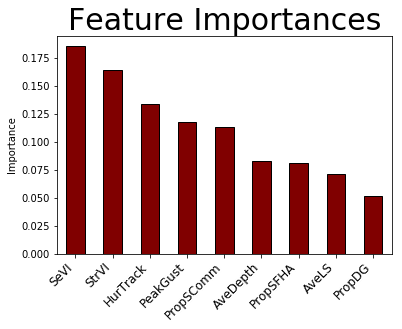

In [123]:
# EXAMPLE
gini_importance_plot(df_gini_importances)

## Permutation Importance Calculation

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is rectangular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled 1. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

The permutation_importance function calculates the feature importance of estimators for a given dataset. The n_repeats parameter sets the number of times a feature is randomly shuffled and returns a sample of feature importances. Permutation importances can either be computed on the training set or an held-out testing or validation set. Using a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit.

In [39]:
def calc_permutation_importance(criterion, model, df_x, y):
    features = df_x.columns.values
    X = df_x.as_matrix()
    Y = y.as_matrix()
    scores = defaultdict(list)
    rf = model
    for train_idx, test_idx in ShuffleSplit(len(X), 100, .3, random_state=42): #number of splits, absolute number of test samples, proportion of data in train split
        X_train, X_test = X[train_idx], X[test_idx] #Random permutation cross-validator, Yields indices to split data into training and test sets.
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        r = rf.fit(X_train, Y_train)
        acc = criterion(Y_test, rf.predict(X_test))
        for i in range(X.shape[1]): #The shape attribute for numpy arrays returns the dimensions of the array. If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n.
            X_t = X_test.copy()
            np.random.seed(42)
            np.random.shuffle(X_t[:, i]) #rearranging randomly
            shuff_acc = criterion(Y_test, rf.predict(X_t)) 
            scores[features[i]].append((acc-shuff_acc)/acc) #change in importance, actual - shuffled/actual, this is percent error        
    mda_features = [f for f in scores.keys()]
    mda_importance = [(np.mean(score)) for score in scores.values()] #average over all the shuffled permutations
    mda_indices = np.argsort(mda_importance)
    return mda_features, mda_importance, mda_indices

In [40]:
#EXAMPLE
#criterion can be r2_score or mean_squared_error
criterion = r2_score
mda_features, mda_importance, mda_indices = calc_permutation_importance(criterion, reg_model, df_x, y)

## Permutation Plot

In [41]:
def permutation_importance_plot(mda_features, mda_importance):
    df_perm_FI = pd.DataFrame({'Feature':mda_features, 'Importance':[abs(number) for number in mda_importance]})
    df_perm_FI.sort_values('Importance', ascending=False).plot.bar('Feature',
                                                                   'Importance', 
                                                                    color='maroon', 
                                                                    legend = False)
    plt.title("Feature Importances", fontsize = 30)
    plt.ylabel('Importance')
    plt.xlabel('')
    plt.xticks(fontsize = 12, rotation = 45, ha='right')

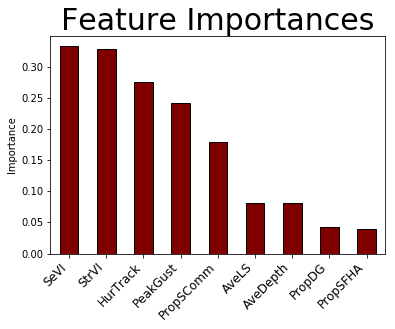

In [42]:
# EXAMPLE
permutation_importance_plot(mda_features, mda_importance)

## Export

In [170]:
train_set = x_train.copy()
test_set = x_test.copy()

In [171]:
train_set['y_train'] = y_train
train_set['train_pred'] = pred_train

test_set['y_test'] = y_test
test_set['test_pred'] = pred_test

In [173]:
train_set.to_excel("/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/train_set_20191031.xlsx")
test_set.to_excel("/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/test_set_20191031.xlsx")